In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

pi = np.pi

MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'
royalpurple = '#9e00a3'
lavender = '#cc98d9'



In [2]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/exoarchive_ipac_confirmed_200507.csv'  #reading in file

raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[77]
VALUES = raw_data[78:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return arr

In [3]:
'''
What I need:
- star name 
- planet radius --> comes from planet mass
- star mass
- planet mass
- planet semi-major axis --> comes from planet's period
- star radius
'''

d = {}
d['starname'] = get_key('pl_hostname')  #get star name

d['radius'] = get_key('pl_radj')  #get radius of planets (Jupiter radius)
d['star_radius'] = get_key('st_rad')  #get radius of star (solar radii)

d['mp'] = get_key('pl_bmassj')  #get mass of planets (in Jupiter masses)
                                #mass can be expressed as Msin(i), where i is the inclination

d['ms'] = get_key('st_mass')  #get mass of stars (in solar masses)

d['a'] = get_key('pl_orbsmax')  #get planet's semi-major axis (in AU)

d['p'] = get_key('pl_orbper')  #get planet's period (in days)

In [4]:
def is_number(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

stars = []   #convert to arrays
rp = []
rs = []
mp = []
ms = []
a = []
p = []

for i in range(len(d['a'])):
    if is_number(d['mp'][i]) and is_number(d['ms'][i]) and is_number(d['a'][i]) and is_number(d['star_radius'][i]) \
    and is_number(d['p'][i]):
        stars.append(d['starname'][i])
        rp.append(d['radius'][i])
        mp.append(d['mp'][i])
        ms.append(d['ms'][i])
        a.append(d['a'][i])
        rs.append(d['star_radius'][i])
        p.append(d['p'][i])
        
for i in range(len(mp)):
    if rp[i] == '':
        m = float(mp[i])                                             #using the mass-radius relation to convert m to r
        if m*MJUPITER/MEARTH <= 2:                                   #coefficients taken from Chen and Kipping (2016)
            rp[i] = str(((m*MJUPITER/MEARTH)**0.28)*REARTH/RJUPITER)
        elif m <= 0.41:
            rp[i] = str((((m*MJUPITER/MEARTH)**0.59)*REARTH - 1.483*REARTH)/RJUPITER)
        elif m*MJUPITER/MSUN <= 0.08:
            rp[i] = str((((m*MJUPITER/MEARTH)**-0.04)*REARTH + 10.179*REARTH)/RJUPITER)
        else:
            rp[i] = str(((m*MJUPITER/MEARTH)**0.88)*REARTH/RJUPITER)

In [5]:
def convert_to_float(arr):
    final = []
    for a in arr:
        final.append(float(a))
    return final

rp = convert_to_float(rp)
rs = convert_to_float(rs)
mp = convert_to_float(mp)
ms = convert_to_float(ms)
a = convert_to_float(a)
p = convert_to_float(p)

In [6]:
uniquestars = []
for s in stars:
    if s not in uniquestars:              #one instance of each star in uniquestars
        uniquestars.append(s)

In [7]:
def split_array(arr, s = stars, u = uniquestars):
    final_array = []
    corresponding_stars = []
    for i in range(len(u)):
        mini_array = []
        for j in range(len(s)):
            if s[j] == u[i]:
                mini_array.append(arr[j])
        if len(mini_array) >= 3:
            final_array.append(mini_array)
            corresponding_stars.append(u[i])
    return final_array, corresponding_stars

rs_final, stars_that_matter = split_array(rs)
rp_final, stars_that_matter = split_array(rp)
mp_final, stars_that_matter = split_array(mp)
ms_final, stars_that_matter = split_array(ms)
a_final, stars_that_matter = split_array(a)
p_final, stars_that_matter = split_array(p)

mu_final = []
for i in range(len(mp_final)):
    mu_final.append(archinfo.mu((MJUPITER/MEARTH)*np.array(mp_final[i]), ms_final[i][0]))
    
rs_raw = []
for i in range(len(rs_final)):
    for j in range(len(rs_final[i])):
        rs_raw.append(rs_final[i][j])
        
rp_raw = []
for i in range(len(rp_final)):
    for j in range(len(rp_final[i])):
        rp_raw.append(rp_final[i][j])
    
p_raw = []
for i in range(len(p_final)):
    for j in range(len(p_final[i])):
        p_raw.append(p_final[i][j])

[1078.0, 2391.0, 14002.0] 47 UMa
[14.65152, 44.4175, 4825.0, 0.736539, 262.0] 55 Cnc
[4.215, 38.021, 123.01] 61 Vir
[18.57, 6.584, 2.882, 5.516] DMPP-1
[3.5951, 15.624, 35.747] EPIC 249893012
[3.204, 6.689, 13.031] GJ 1061
[1.22003, 5.974, 257.8] GJ 3138
[30.5987, 122.6196, 48.1345, 13.2543] GJ 3293
[3.93072, 9.1247, 55.661] GJ 357
[5.3686, 12.914, 3.149] GJ 581
[61.1166, 30.0881, 1.93778, 124.26] GJ 876
[1.2089819, 3.6480957, 6.2014698] GJ 9827
[5.75969, 16.357, 49.748, 122.744, 604.67, 2205.0] HD 10180
[557.04, 4.15514, 2835.0] HD 125612
[9.3743, 962.0, 2172.0] HD 181433
[5.75999, 7.28243, 10.86499, 25.1967] HD 215152
[3.092926, 6.76458, 46.859, 22.717, 94.2, 2247.0] HD 219134
[1049.0, 214.67, 117.87, 49.175, 676.8, 5700.0] HD 34445
[5.39792, 15.299, 24.451] HD 7924
[6.673892, 147.747, 981.8] HIP 14810
[8.1352, 32.03, 431.7] HIP 57274
[0.658524, 7.814, 14.697, 19.482] K2-266
[3.471745, 7.138048, 10.45582, 14.76289] K2-285
[3.743208, 10.423648, 22.342989, 54.32031] KOI-94
[3.1800218, 

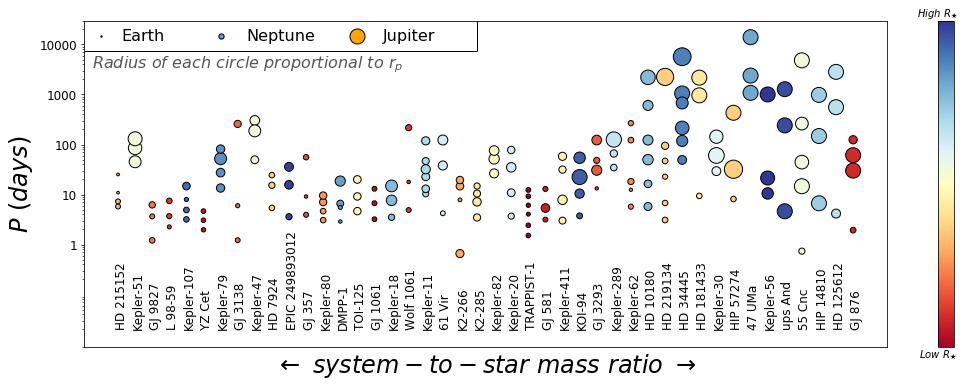

In [8]:
mu_rank = np.array(stats.rankdata(mu_final), dtype = 'int')
mu_pos = []
for i in range(len(mu_final)):
    for j in range(len(mp_final[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')

rs_rank = np.array(stats.rankdata(rs_raw)-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

for i in range(len(rp_final)):
    print(str(p_final[i]) + " " + stars_that_matter[i])
   
plt.scatter(mu_pos, p_raw, c = rs_rank, cmap = cm, s = 225*np.array(rp_raw), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(rs_rank), max(rs_rank))
cbar.set_ticks([])
cbar.ax.text(1, -5, r"$Low\ R_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 168, r"$High\ R_{\bigstar}$", va = 'top', ha = 'center')


for i in range(len(rp_final)):
    plt.text(mu_rank[i]-0.2, 0.02, stars_that_matter[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

plt.ylim(0.009, 30000)



plt.hlines(7500, -1, 22, lw = 1)
plt.vlines(22, 7500, 30000, lw = 1)
plt.plot(0, 15000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(1.2, 15000, 'Earth', va='center', fontsize=16)
plt.plot(7, 15000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(8.5, 15000, 'Neptune', va='center', fontsize=16)
plt.plot(15, 15000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(16.5, 15000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.5,6500, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')
plt.show()

In [9]:
N_final = []
for i in range(len(mp_final)):
    N_final.append(len(mp_final[i]))

#we already have mu_final

sv_p_final = p_final
sv_mp_final = mp_final 
for i in range(len(mp_final)):
    sv_p_final[i] = np.array(p_final[i])
    sv_mp_final[i] = (MJUPITER/MEARTH)*np.array(mp_final[i])
    order = np.argsort(sv_p_final[i])
    sv_p_final[i] = sv_p_final[i][order]
    sv_mp_final[i] = sv_mp_final[i][order]

Q_final = []
for i in range(len(mp_final)):
    Q_final.append(archinfo.Q(sv_mp_final[i]))
    
M_final = []
for i in range(len(mp_final)):
    M_final.append(archinfo.M(sv_p_final[i], sv_mp_final[i]))
    
S_final = []
for i in range(len(mp_final)):
    S_final.append(archinfo.S(sv_p_final[i], sv_mp_final[i], ms_final[i][0]))

    
C_final = []
for i in range(len(p_final)):
    C_final.append(archinfo.C(sv_p_final[i])[0])


for i in range(len(S_final)):
    print(str(int(S_final[i])) + " " + stars_that_matter[i])


N_final = np.array(N_final)
Q_final = np.array(Q_final)
M_final = np.array(M_final)
S_final = np.array(S_final)
C_final = np.array(C_final)
logmu_final = np.log10(np.array(mu_final))

log_mu_over_N = []
for i in range(len(mu_final)):
    log_mu_over_N.append(np.log10(mu_final[i]/N_final[i]))
log_mu_over_N = np.array(log_mu_over_N)

8 47 UMa
17 55 Cnc
32 61 Vir
16 DMPP-1
25 EPIC 249893012
15 GJ 1061
54 GJ 3138
11 GJ 3293
28 GJ 357
11 GJ 581
7 GJ 876
25 GJ 9827
21 HD 10180
13 HD 125612
16 HD 181433
17 HD 215152
22 HD 219134
12 HD 34445
17 HD 7924
13 HIP 14810
12 HIP 57274
25 K2-266
10 K2-285
15 KOI-94
15 Kepler-107
13 Kepler-11
15 Kepler-18
21 Kepler-20
13 Kepler-289
5 Kepler-30
17 Kepler-411
20 Kepler-47
17 Kepler-51
11 Kepler-56
16 Kepler-62
17 Kepler-79
9 Kepler-80
10 Kepler-82
16 L 98-59
17 TOI-125
10 TRAPPIST-1
35 Wolf 1061
11 YZ Cet
14 ups And


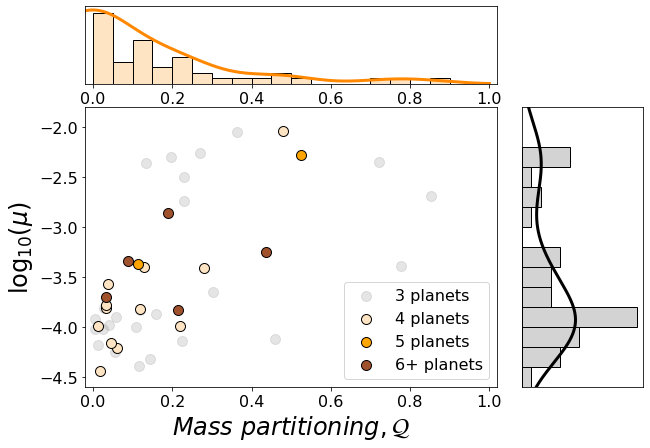

In [10]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(Q_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(Q_final[N_final==4], logmu_final[N_final==4], c='bisque', edgecolor='k', s=100, label='4 planets')
ax1.scatter(Q_final[N_final==5], logmu_final[N_final==5], c='orange', edgecolor='k', s=100, label='5 planets')
ax1.scatter(Q_final[N_final>=6], logmu_final[N_final>=6], c='sienna', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)

ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(-4.6, -1.8)

#Q histogram
x = np.linspace(-1, 1, 1000)
y = FFTKDE(kernel = 'gaussian', bw = 'silverman').fit(np.hstack([-Q_final, Q_final])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(Q_final, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
ax1h.plot(x, y*3, c='#ff8800', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])
ax1h.tick_params(labelsize=16)


plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: p-value capped: true value larger than 0.25


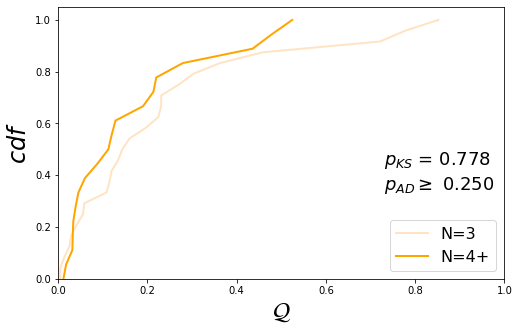

In [11]:
#Q cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

Q3 = Q_final[N_final==3]
Q4 = Q_final[N_final>=4]

Q3 = np.sort(np.squeeze(Q3))
Q4 = np.sort(np.squeeze(Q4))

ax.plot(Q3, np.linspace(0,1,len(Q3)), lw=2, color='bisque', label='N=3')
ax.plot(Q4, np.linspace(0,1,len(Q4)), lw=2, color='orange', label='N=4+')
ax.set_xlim(0,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(Q3, Q4))
AD = stats.anderson_ksamp([Q3, Q4])[2]

ax.text(0.73, 0.5, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(0.73, 0.4, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.show()

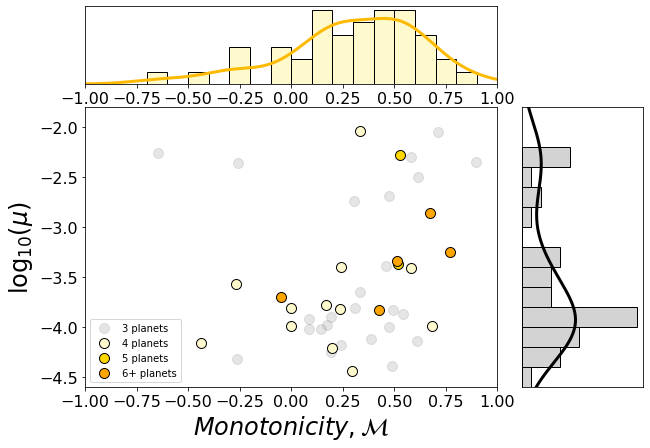

In [12]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# M vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(M_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(M_final[N_final==4], logmu_final[N_final==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
ax1.scatter(M_final[N_final==5], logmu_final[N_final==5], c='gold', edgecolor='k', s=100, label='5 planets')
ax1.scatter(M_final[N_final>=6], logmu_final[N_final>=6], c='orange', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower left', frameon=True, fontsize=10)
ax1.tick_params(labelsize=16)

ax1.set_xlim(-1, 1)
ax1.set_ylim(-4.6, -1.8)

#M histogram
x = np.linspace(-1.5,1.5,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M_final)).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(M_final, bins=np.arange(-1.5,1.5,0.1), density=True, color='lemonchiffon', edgecolor='k')
ax1h.plot(x, y, c='#fcba03', lw=3)
ax1h.set_xlim(-1,1)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])

ax1h.tick_params(labelsize=16)

plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: p-value capped: true value larger than 0.25


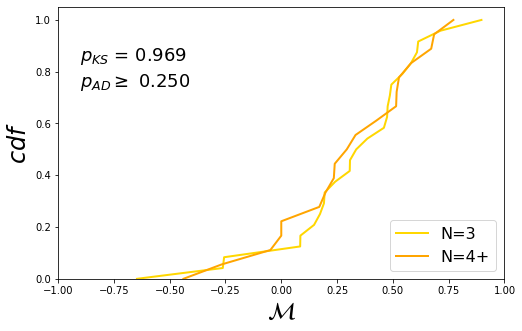

In [13]:
#M cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

M3 = M_final[N_final==3]
M4 = M_final[N_final>=4]

M3 = np.sort(np.squeeze(M3))
M4 = np.sort(np.squeeze(M4))

ax.plot(M3, np.linspace(0,1,len(M3)), lw=2, color='gold', label='N=3')
ax.plot(M4, np.linspace(0,1,len(M4)), lw=2, color='orange', label='N=4+')
ax.set_xlim(-1,1)
ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(M3, M4))
AD = stats.anderson_ksamp([M3, M4])[2]

ax.text(-0.9, 0.9, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(-0.9, 0.8, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.show()

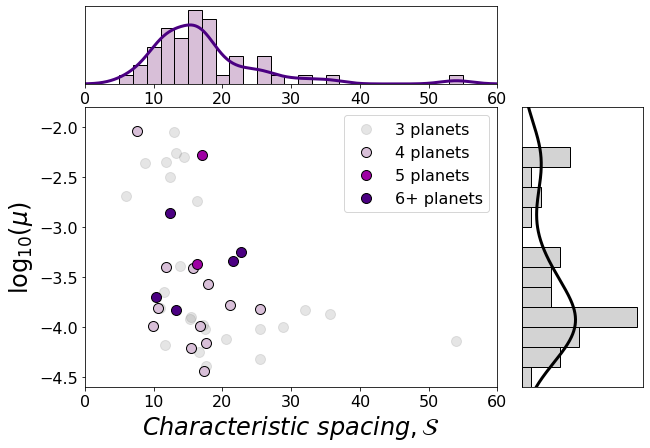

In [14]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# S vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(S_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(S_final[N_final==4], logmu_final[N_final==4], c='thistle', edgecolor='k', s=100, label='4 planets')
ax1.scatter(S_final[N_final==5], logmu_final[N_final==5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
ax1.scatter(S_final[N_final>=6], logmu_final[N_final>=6], c='indigo', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='upper right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)

ax1.set_xlim(0, 60)
ax1.set_ylim(-4.6, -1.8)

#S histogram
x = np.linspace(-1,100,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S_final)).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(S_final, bins=np.arange(-1,75,2), density=True, color='thistle', edgecolor='k')
ax1h.plot(x, y, c='indigo', lw=3)
ax1h.set_xlim(0, 60)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])

plt.show()



C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: p-value capped: true value larger than 0.25


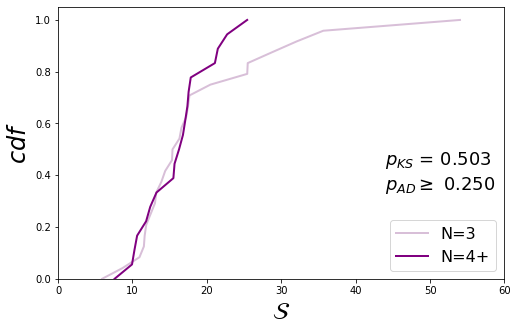

In [15]:
#S cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

S3 = S_final[N_final==3]
S4 = S_final[N_final>=4]

S3 = np.sort(np.squeeze(S3))
S4 = np.sort(np.squeeze(S4))

ax.plot(S3, np.linspace(0,1,len(S3)), lw=2, color='thistle', label='N=3')
ax.plot(S4, np.linspace(0,1,len(S4)), lw=2, color='purple', label='N=4+')
ax.set_xlim(0,60)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(S3, S4))
AD = stats.anderson_ksamp([S3, S4])[2]

ax.text(44, 0.5, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(44, 0.4, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.show()

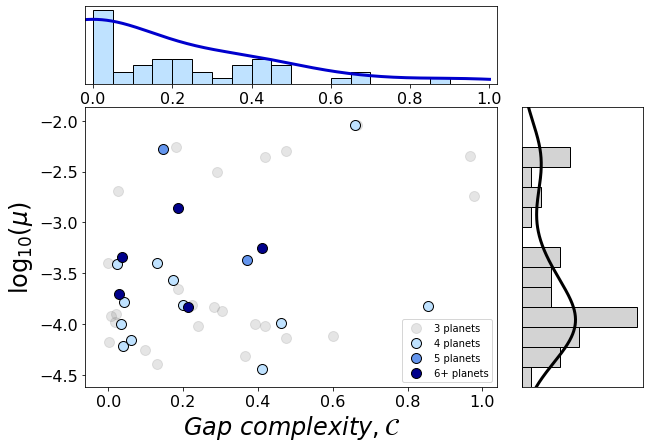

In [16]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# C vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(C_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(C_final[N_final==4], logmu_final[N_final==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
ax1.scatter(C_final[N_final==5], logmu_final[N_final==5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
ax1.scatter(C_final[N_final>=6], logmu_final[N_final>=6], c='darkblue', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=10)
ax1.tick_params(labelsize=16)

#C histogram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-C_final, C_final])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(C_final, bins=np.arange(-1,1,0.05), density=True, color=robinseggblue, edgecolor='k')
ax1h.plot(x, y*4, c='mediumblue', lw=3)
ax1h.set_xlim(-0.02, 1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])

plt.show()


C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: p-value capped: true value larger than 0.25


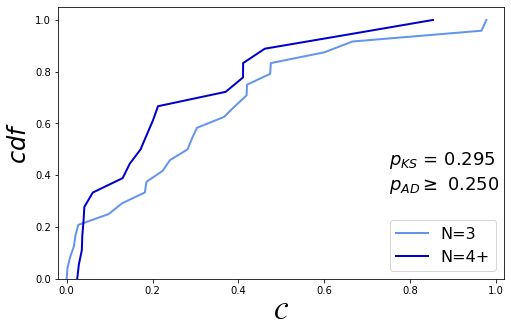

In [17]:
#C cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

C3 = C_final[N_final==3]
C4 = C_final[N_final>=4]

C3 = np.sort(np.squeeze(C3))
C4 = np.sort(np.squeeze(C4))

ax.plot(C3, np.linspace(0,1,len(C3)), lw=2, color='cornflowerblue', label='N=3')
ax.plot(C4, np.linspace(0,1,len(C4)), lw=2, color='mediumblue', label='N=4+')
ax.set_xlim(-0.02,1.02)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(C3, C4))
AD = stats.anderson_ksamp([C3, C4])[2]

ax.text(0.75, 0.5, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(0.75, 0.4, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: p-value capped: true value larger than 0.25
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: p-value capped: true value larger than 0.25


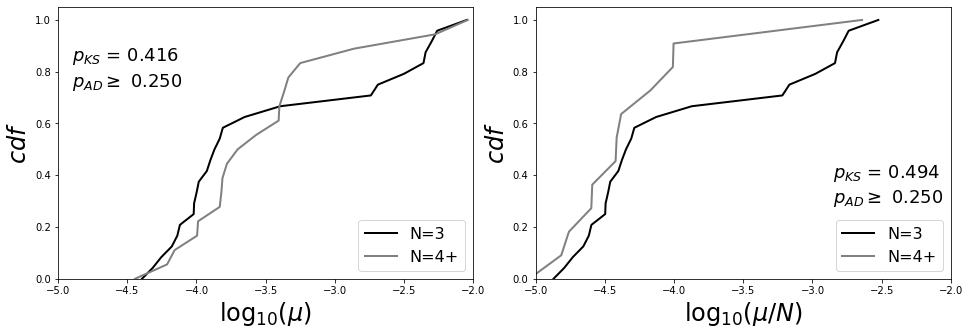

In [18]:
#mu cdf
fix, axes = plt.subplots(1, 2, figsize = (16, 5))

plt.subplots_adjust(wspace = 0.15)

ax = axes[0]

mu3 = logmu_final[N_final==3]
mu4 = logmu_final[N_final>=4]

mu3 = np.sort(np.squeeze(mu3))
mu4 = np.sort(np.squeeze(mu4))

ax.plot(mu3, np.linspace(0,1,len(mu3)), lw=2, color='black', label='N=3')
ax.plot(mu4, np.linspace(0,1,len(mu4)), lw=2, color='grey', label='N=4+')
ax.set_xlim(-5,-2)
ax.set_xlabel(r'$\log_{10}(\mu)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(mu3, mu4))
AD = stats.anderson_ksamp([mu3, mu4])[2]

ax.text(-4.9, 0.9, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(-4.9, 0.8, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

ax = axes[1]

log_mu_over_N3 = log_mu_over_N[N_final==3]
log_mu_over_N4 = log_mu_over_N[N_final==4]

log_mu_over_N3 = np.sort(np.squeeze(log_mu_over_N3))
log_mu_over_N4 = np.sort(np.squeeze(log_mu_over_N4))

ax.plot(log_mu_over_N3, np.linspace(0,1,len(log_mu_over_N3)), lw=2, color='black', label='N=3')
ax.plot(log_mu_over_N4, np.linspace(0,1,len(log_mu_over_N4)), lw=2, color='grey', label='N=4+')
ax.set_xlim(-5,-2)
ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(log_mu_over_N3, log_mu_over_N4))
AD = stats.anderson_ksamp([log_mu_over_N3, log_mu_over_N4])[2]

ax.text(-2.85, 0.45, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(-2.85, 0.35, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')


plt.show()

In [19]:
MAINPATH = 'C:/Users/djhoo/Documents/maiasaurus-master/'
cks_file = MAINPATH + 'catalogues/clean_kepler_catalogue.csv'

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def get_key(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname']    = get_key('id_starname')             # star id - 'K00082'
d['koi']         = get_key('id_koicand')
d['kic']         = get_key('id_kic')                  # Kepler Input Catalogue ID
d['disposition'] = get_key('koi_disposition')         # status - 'CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', etc.
d['falsepos']    = get_key('cks_fp')                  # CKS false positive designation - 'False' or 'True'
d['snr']         = get_key('koi_model_snr')           # transit signal-to-noise
d['npl']         = get_key('koi_count')               # number of planets in system

d['period']      = get_key('koi_period')              # period (days)
d['period_err1'] = get_key('koi_period_err1')
d['period_err2'] = get_key('koi_period_err2')

d['rprs']      = get_key('koi_ror')                   # planet-to-star radius ratio
d['rprs_err1'] = get_key('koi_ror_err1')
d['rprs_err2'] = get_key('koi_ror_err2')

d['impact']      = get_key('koi_impact')              # impact parameter
d['impact_err1'] = get_key('koi_impact_err1')
d['impact_err2'] = get_key('koi_impact_err2')

d['koi_duration']      = get_key('koi_duration')      # transit duration (hours)
d['koi_duration_err1'] = get_key('koi_duration_err1')
d['koi_duration_err2'] = get_key('koi_duration_err2')

d['rp']      = get_key('iso_prad')                    # CKS+isochrone constrained planet radius (earth radius)
d['rp_err1'] = get_key('iso_prad_err1')
d['rp_err2'] = get_key('iso_prad_err2')

d['sma']      = get_key('iso_sma')                    # CKS+isochrone constrained semi-major axis (AU)
d['sma_err1'] = get_key('iso_sma_err1')
d['sma_err2'] = get_key('iso_sma_err2')

d['rstar']      = get_key('iso_srad')                 # CKS+isochrone constrained stellar radius (solar radius)
d['rstar_err1'] = get_key('iso_srad_err1')
d['rstar_err2'] = get_key('iso_srad_err2')

d['mstar']      = get_key('iso_smass')                # CKS+isochrone constrained stellar mas (solar mass)
d['mstar_err1'] = get_key('iso_smass_err1')
d['mstar_err2'] = get_key('iso_smass_err2')

def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew

d = convert_floats(d)

d['mp'] = np.load(MAINPATH + 'catalogues/cks_pred_masses_oct9.npy')[0]

['', 'id_starname', 'id_kic', 'id_koicand', 'id_kepler_name', 'koi_disposition', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_ror', 'koi_ror_err1', 'koi_ror_err2', 'koi_srho', 'koi_srho_err1', 'koi_srho_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1', 'koi_sma_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_dor', 'koi_dor_err1', 'koi_dor_err2', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_smet', 'koi_smet_err1', 'koi_smet_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_smass', 'koi_smass_err1', '

In [20]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [21]:
uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    s.Rstar   = d['rstar'][d['starname']==us][0]
    
    # pull planetary data
    s.rprs    = d['rprs'][d['starname']==us]
    s.masses  = d['mp'][d['starname']==us]
    s.periods = d['period'][d['starname']==us]

    # pull transit durations and errors, convert hrs to days
    s.dur     = d['koi_duration'][d['starname']==s.sysid]/24
    s.dur_err = 0.5*((d['koi_duration_err1'][d['starname']==s.sysid]) -
                     (d['koi_duration_err2'][d['starname']==s.sysid]))/24
    
    # sort masses, periods, and durations by period
    order = np.argsort(s.periods)
    
    s.rprs    = s.rprs[order]
    s.masses  = s.masses[order]
    s.periods = s.periods[order]
    s.dur     = s.dur[order]
    s.dur_err = s.dur_err[order]
    
    
    # calculate complexity measures (N, mu, Q, M, S, C, f)
    s.N  = len(s.masses)
    s.mu = archinfo.mu(s.masses, s.Mstar)
    s.Q  = archinfo.Q(s.masses)
    s.M  = archinfo.M(s.periods, s.masses)
    s.S  = archinfo.S(s.periods, s.masses, s.Mstar)
    s.C  = archinfo.C(s.periods)
    s.f  = archinfo.f(s.periods, s.Mstar/s.Rstar**3, s.rprs, s.dur, s.dur_err)
      
    systems.append(s)

C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:48: RuntimeWarning: invalid value encountered in sqrt
  term2  = (term2a - term2b*term2c)**(1/2)
C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:186: UserWarning: Complexity is undefined for N < 3; returning NaN
  warnings.warn('Complexity is undefined for N < 3; returning NaN')


In [22]:
Nsys = len(uniquesys)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
M  = np.zeros(Nsys)
S  = np.zeros(Nsys)
C  = np.zeros(Nsys)
f  = np.zeros(Nsys)

for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    M[i]  = s.M
    S[i]  = s.S
    C[i]  = s.C
    f[i]  = s.f

logmu = np.log10(mu)

In [27]:
print("KS between transit and RV data")
KS_logmu = np.array(stats.ks_2samp(logmu, logmu_final))[1]
print("logmu: " + str(KS_logmu))
KS_Q = np.array(stats.ks_2samp(Q, Q_final))[1]
print("Q: " + str(KS_Q))
KS_M = np.array(stats.ks_2samp(M, M_final))[1]
print("M: " + str(KS_M))
KS_S = np.array(stats.ks_2samp(S, S_final))[1]
print("S: " + str(KS_S))
KS_C = np.array(stats.ks_2samp(C, C_final))[1]
print("C: " + str(KS_C))

print("")
print("AD between transit and RV data")
AD_logmu = stats.anderson_ksamp([logmu, logmu_final])[2]
print("logmu: < " + str(AD_logmu))
AD_Q = stats.anderson_ksamp([Q, Q_final])[2]
print("Q: " + str(AD_Q))
AD_M = stats.anderson_ksamp([M, M_final])[2]
print("M: " + str(AD_M))
AD_S = stats.anderson_ksamp([S, S_final])[2]
print("S: < " + str(AD_S))
AD_C = stats.anderson_ksamp([C, C_final])[2]
print("C: < " + str(AD_C))

KS between transit and RV data
logmu: 3.9535893198274373e-16
Q: 0.009081436613974182
M: 0.003219555012438472
S: 1.0549868207804804e-08
C: 9.062418164395865e-14

AD between transit and RV data
logmu: < 0.001
Q: 0.0035147578084526233
M: 0.001491558002284168
S: < 0.001
C: < 0.001


C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: p-value floored: true value smaller than 0.001
  from ipykernel import kernelapp as app
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: p-value floored: true value smaller than 0.001
